In [17]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_predict
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import optuna
import math
import optuna.visualization as vis
import kagglehub
from IPython.display import display, Markdown

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'
    
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

../kaggle/input/submission.csv
../kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv
../kaggle/input/playground-series-s4e11/sample_submission.csv
../kaggle/input/playground-series-s4e11/test.csv
../kaggle/input/playground-series-s4e11/train.csv


# Intoduction

In this exploratory data analysis (EDA), we aim to gain a deeper understanding of the dataset by performing the following key steps:

- Understand the structure of the data: Identify data types, feature distributions, and basic statistics.
- Explore patterns and relationships: Examine correlations, feature interactions, and potential trends.
- Detect missing values: Identify incomplete data and evaluate possible imputation strategies.
- Identify outliers: Locate extreme values that may impact model performance or require transformation.

This analysis will provide valuable insights to guide further data preprocessing and modeling decisions.

# Load Data

In [18]:
# Load the data
train_original = pd.read_csv(data_path + '/playground-series-s4e11/train.csv')
test_original = pd.read_csv(data_path + '/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv(data_path + '/playground-series-s4e11/sample_submission.csv')
original_data = pd.read_csv(data_path + '/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

# Quick Overview

In [19]:
train_original.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [20]:
test_original.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [21]:
original_data.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [22]:
sample_submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


In [23]:
original_data.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


# Overview

In [24]:
def data_overview(data, target):
    # Overview
    display(Markdown("## Data Overview"))
    
    display(Markdown("### General Information"))
    display(Markdown(f"- Number of rows and columns: {data.shape[0]} x {data.shape[1]}"))
    display(Markdown("- Column names:"))
    display(list(data.columns))

    display(Markdown("### Data Types & Missing Values"))
    missing = data.isnull().sum()
    dtypes = pd.DataFrame(data.dtypes, columns=["Data Type"])
    missing_df = pd.DataFrame(missing, columns=["Missing Values"])
    overview_df = dtypes.join(missing_df)
    display(overview_df.style.background_gradient(cmap="coolwarm"))

    display(Markdown("### Classic head of Data"))
    display(data.head().style.set_properties(**{"background-color": "#f5f5f5"}))

    display(Markdown("### Statistical Summary (describe)"))
    display(data.describe().T.style.background_gradient(cmap="viridis"))

    # Target variable analysis
    display(Markdown(f"## Target Variable: `{target}`"))
    sns.set_style("whitegrid")  
    sns.set_palette("viridis")   

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Absolute frequency barplot
    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(), 
                ax=ax[0])  

    ax[0].set_title("Absolute Frequency", fontsize=12, fontweight="bold")
    ax[0].set_ylabel("Count")
    ax[0].set_xlabel(target)
    ax[0].grid(axis="y", linestyle="--", alpha=0.5)  

    # Percentage distribution barplot
    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(normalize=True), 
                ax=ax[1])  

    ax[1].set_title("Percentage Distribution", fontsize=12, fontweight="bold")
    ax[1].set_ylabel("Percentage")
    ax[1].set_xlabel(target)
    ax[1].grid(axis="y", linestyle="--", alpha=0.5)

    

    for spine in ["top", "right"]:
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

## Data Overview

### General Information

- Number of rows and columns: 2556 x 19

- Column names:

['Name',
 'Gender',
 'Age',
 'City',
 'Working Professional or Student',
 'Profession',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'Depression']

### Data Types & Missing Values

,Data Type,Missing Values
Name,object,0
Gender,object,0
Age,int64,0
City,object,0
Working Professional or Student,object,0
Profession,object,673
Academic Pressure,float64,2054
Work Pressure,float64,502
CGPA,float64,2054
Study Satisfaction,float64,2054


### Classic head of Data

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,nan,2.000000,nan,nan,4.000000,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,nan,4.000000,nan,nan,3.000000,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,nan,2.000000,nan,nan,3.000000,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,nan,3.000000,nan,nan,5.000000,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,nan,4.000000,nan,nan,3.000000,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
Age,2556.000000,39.043036,12.260596,18.000000,28.000000,39.000000,50.000000,60.000000
Academic Pressure,502.000000,3.003984,1.390007,1.000000,2.000000,3.000000,4.000000,5.000000
Work Pressure,2054.000000,3.021908,1.417312,1.000000,2.000000,3.000000,4.000000,5.000000
CGPA,502.000000,7.567809,1.465367,5.030000,6.210000,7.605000,8.825000,10.000000
Study Satisfaction,502.000000,3.075697,1.373490,1.000000,2.000000,3.000000,4.000000,5.000000
Job Satisfaction,2054.000000,3.015093,1.418432,1.000000,2.000000,3.000000,4.000000,5.000000
Work/Study Hours,2556.000000,6.023865,3.771743,0.000000,3.000000,6.000000,9.000000,12.000000
Financial Stress,2556.000000,2.968701,1.415527,1.000000,2.000000,3.000000,4.000000,5.000000


## Target Variable: `Depression`

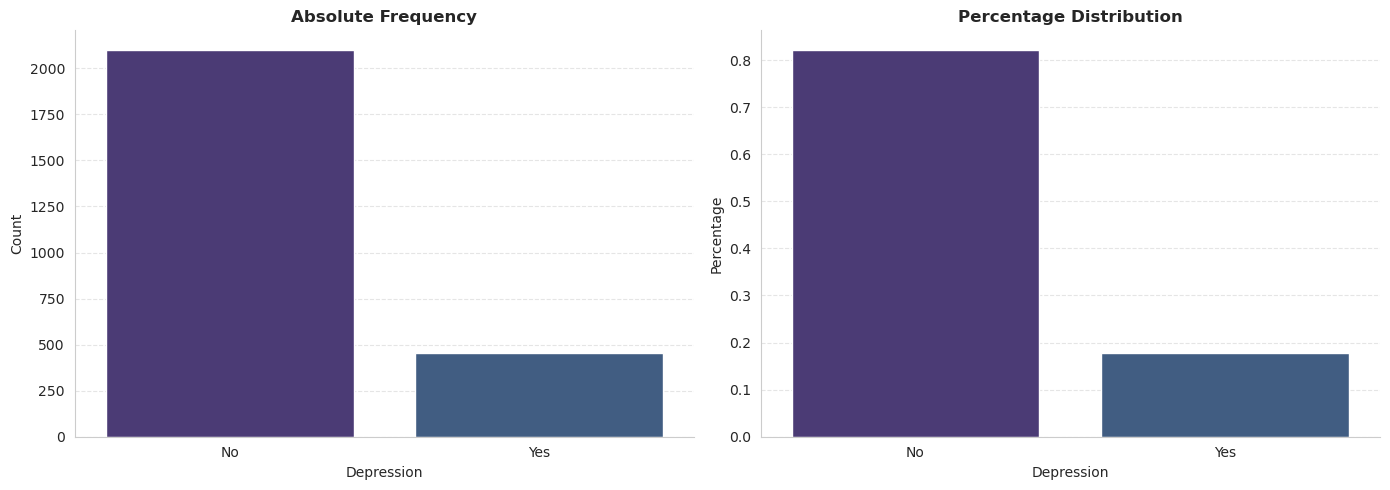

In [25]:
data_overview(original_data, 'Depression')

## Data Overview

### General Information

- Number of rows and columns: 140700 x 20

- Column names:

['id',
 'Name',
 'Gender',
 'Age',
 'City',
 'Working Professional or Student',
 'Profession',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'Depression']

### Data Types & Missing Values

,Data Type,Missing Values
id,int64,0
Name,object,0
Gender,object,0
Age,float64,0
City,object,0
Working Professional or Student,object,0
Profession,object,36630
Academic Pressure,float64,112803
Work Pressure,float64,27918
CGPA,float64,112802


### Classic head of Data

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.000000,Ludhiana,Working Professional,Chef,nan,5.000000,nan,nan,2.000000,More than 8 hours,Healthy,BHM,No,1.000000,2.000000,No,0
1,1,Vivan,Male,26.000000,Varanasi,Working Professional,Teacher,nan,4.000000,nan,nan,3.000000,Less than 5 hours,Unhealthy,LLB,Yes,7.000000,3.000000,No,1
2,2,Yuvraj,Male,33.000000,Visakhapatnam,Student,nan,5.000000,nan,8.970000,2.000000,nan,5-6 hours,Healthy,B.Pharm,Yes,3.000000,1.000000,No,1
3,3,Yuvraj,Male,22.000000,Mumbai,Working Professional,Teacher,nan,5.000000,nan,nan,1.000000,Less than 5 hours,Moderate,BBA,Yes,10.000000,1.000000,Yes,1
4,4,Rhea,Female,30.000000,Kanpur,Working Professional,Business Analyst,nan,1.000000,nan,nan,1.000000,5-6 hours,Unhealthy,BBA,Yes,9.000000,4.000000,Yes,0


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
id,140700.000000,70349.500000,40616.735775,0.000000,35174.750000,70349.500000,105524.250000,140699.000000
Age,140700.000000,40.388621,12.384099,18.000000,29.000000,42.000000,51.000000,60.000000
Academic Pressure,27897.000000,3.142273,1.380457,1.000000,2.000000,3.000000,4.000000,5.000000
Work Pressure,112782.000000,2.998998,1.405771,1.000000,2.000000,3.000000,4.000000,5.000000
CGPA,27898.000000,7.658636,1.464466,5.030000,6.290000,7.770000,8.920000,10.000000
Study Satisfaction,27897.000000,2.944940,1.360197,1.000000,2.000000,3.000000,4.000000,5.000000
Job Satisfaction,112790.000000,2.974404,1.416078,1.000000,2.000000,3.000000,4.000000,5.000000
Work/Study Hours,140700.000000,6.252679,3.853615,0.000000,3.000000,6.000000,10.000000,12.000000
Financial Stress,140696.000000,2.988983,1.413633,1.000000,2.000000,3.000000,4.000000,5.000000
Depression,140700.000000,0.181713,0.385609,0.000000,0.000000,0.000000,0.000000,1.000000


## Target Variable: `Depression`

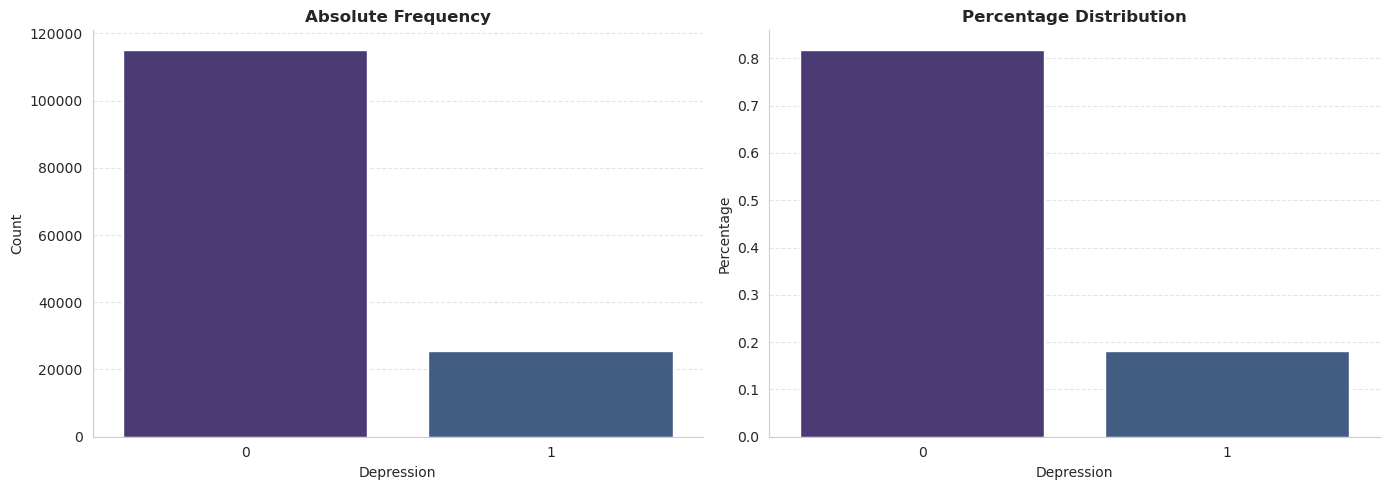

In [26]:
data_overview(train_original, 'Depression')

# Quick PreProcessing about some features

In [27]:
original_data_fix = original_data.copy()
original_data_fix['Depression'] = original_data_fix['Depression'].map({'Yes': 1, 'No': 0})
original_data_fix.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,0
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,0
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,0
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,0
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,0


# Optional Point: Concat the data

In [28]:
#Concat train and the original data set
train = train_original.copy()
train.drop('id', axis=1, inplace=True) #id is not needed for training
train = pd.concat([train, original_data_fix],ignore_index=True)

In [29]:
# just make sure to concat worked,check if the objecte type is the same
train.iloc[train_original.shape[0]-5:train_original.shape[0]+5].head(10)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0
140699,Sai,Male,27.0,Patna,Student,NaN,4.0,NaN,9.24,1.0,NaN,Less than 5 hours,Healthy,BCA,Yes,2.0,3.0,Yes,1
140700,Pooja,Female,37.0,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6.0,2.0,No,0
140701,Reyansh,Male,60.0,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0.0,4.0,Yes,0
140702,Manvi,Female,42.0,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0.0,2.0,No,0
140703,Isha,Female,44.0,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1.0,2.0,Yes,0
140704,Aarav,Male,48.0,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6.0,5.0,Yes,0


# Feature Analyse

## Numeric Feature Attributes

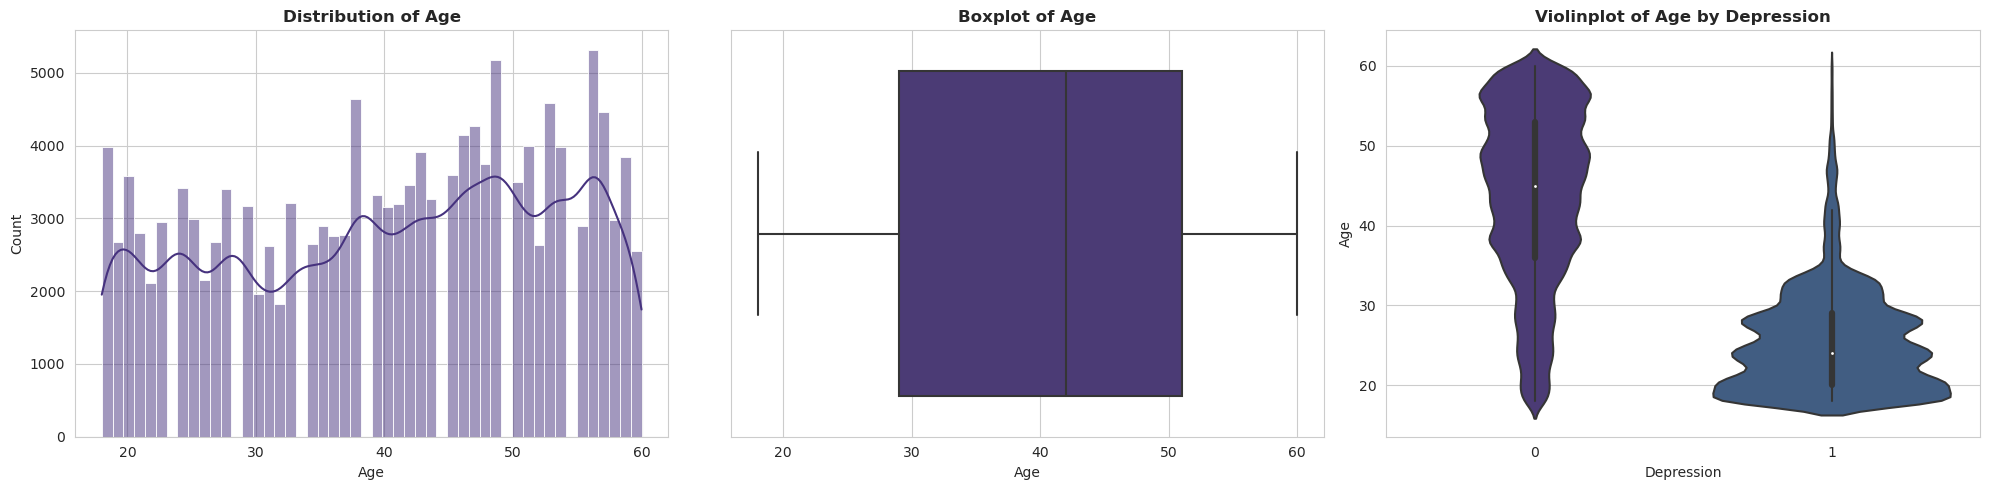

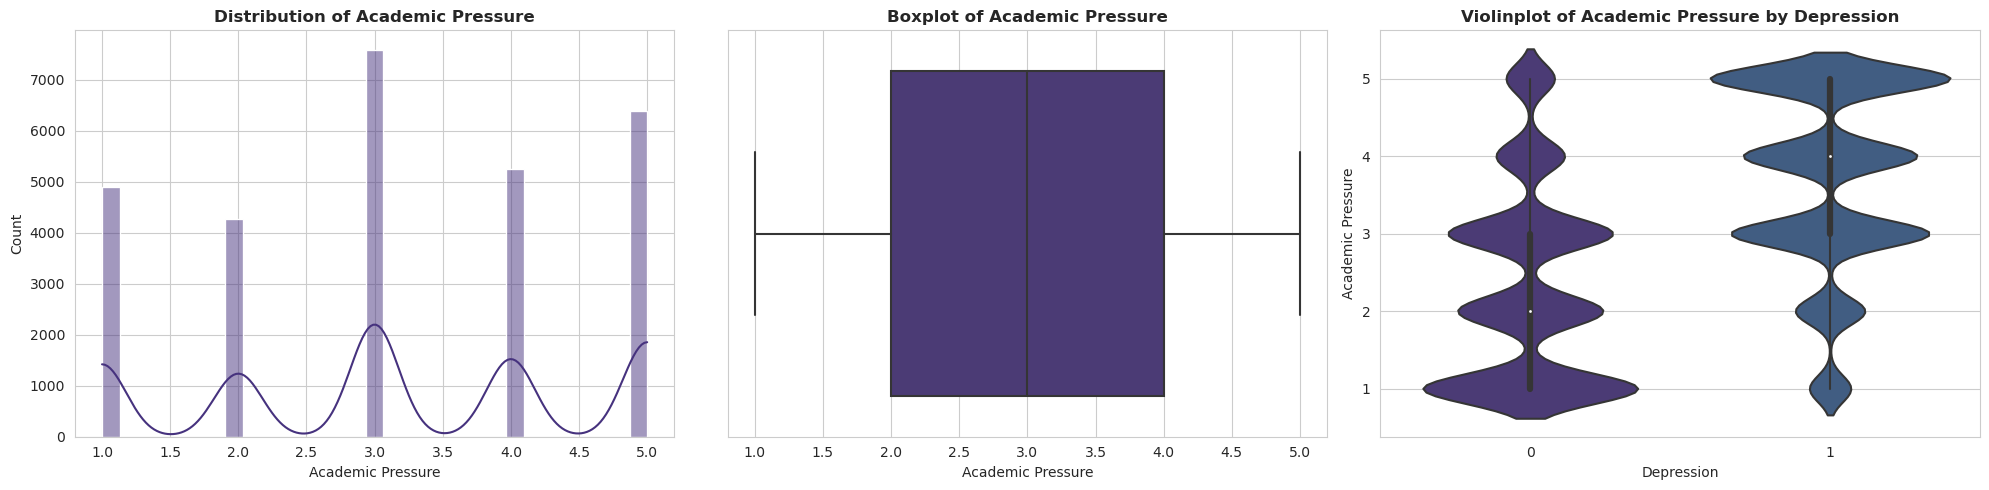

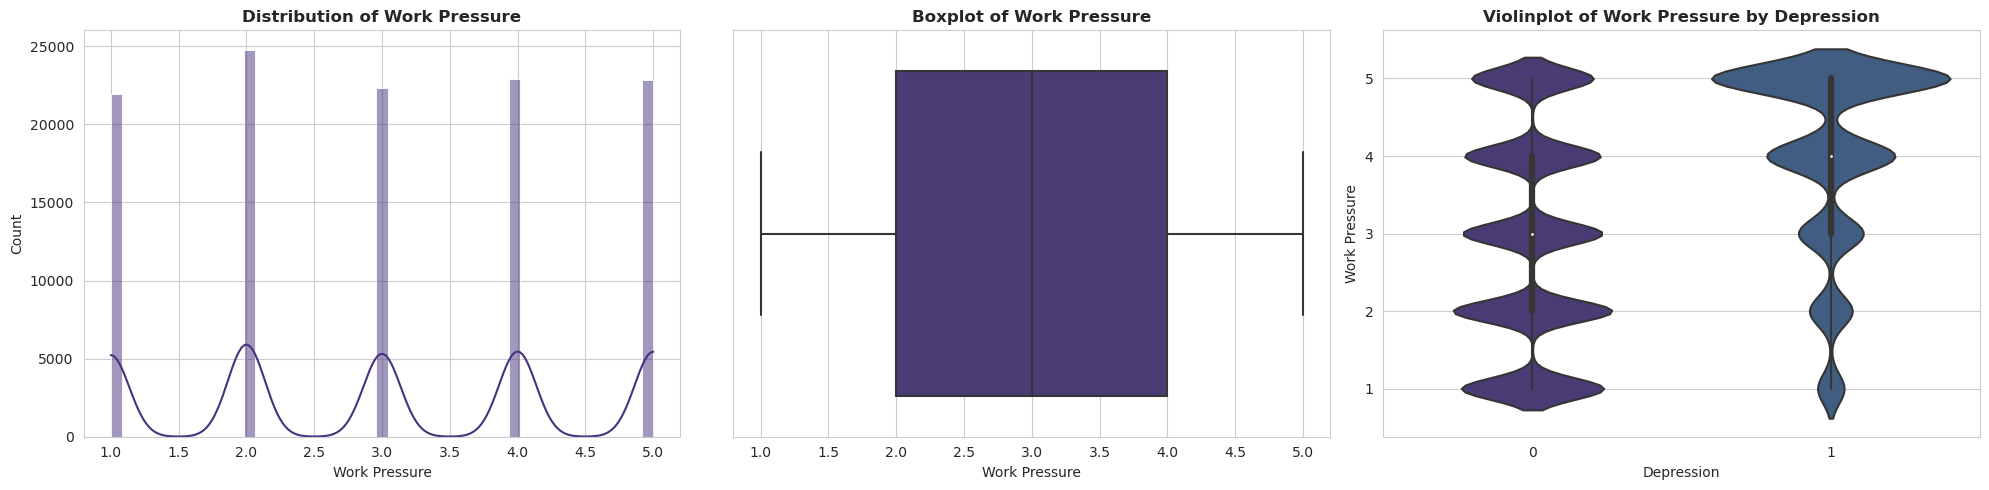

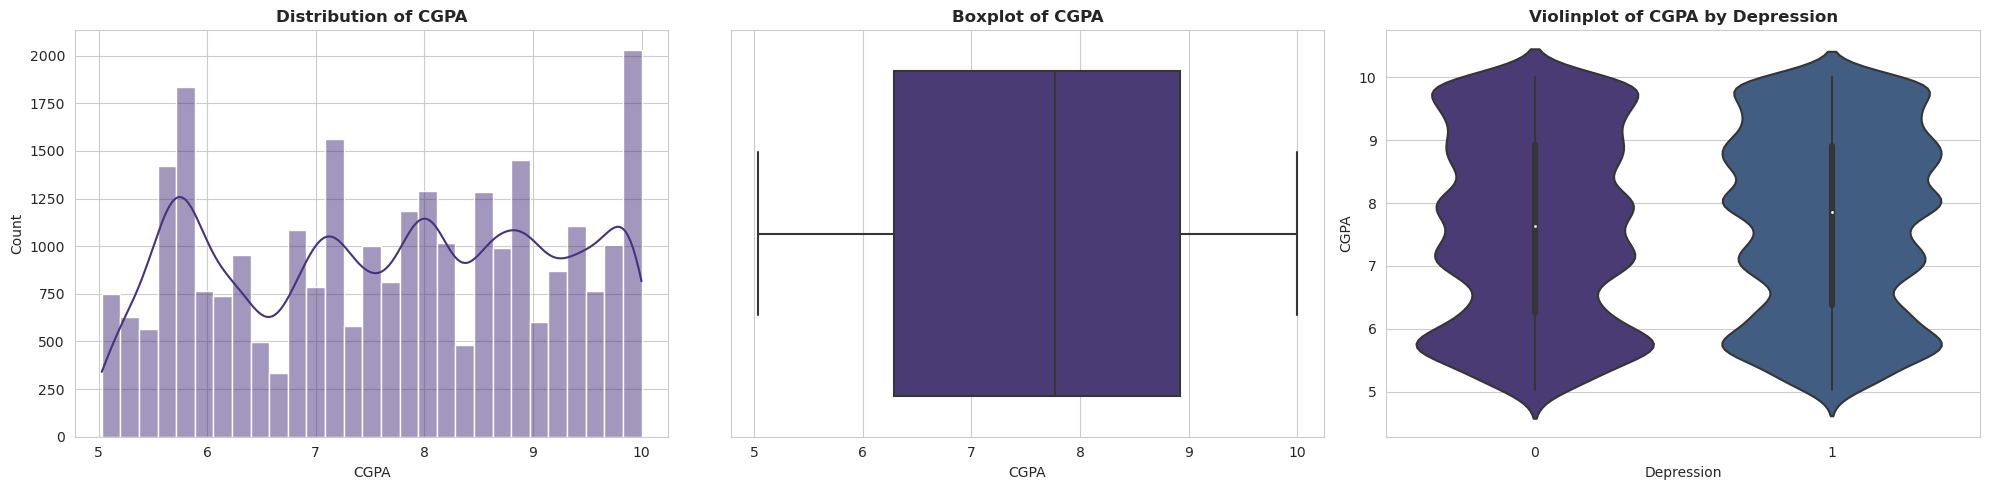

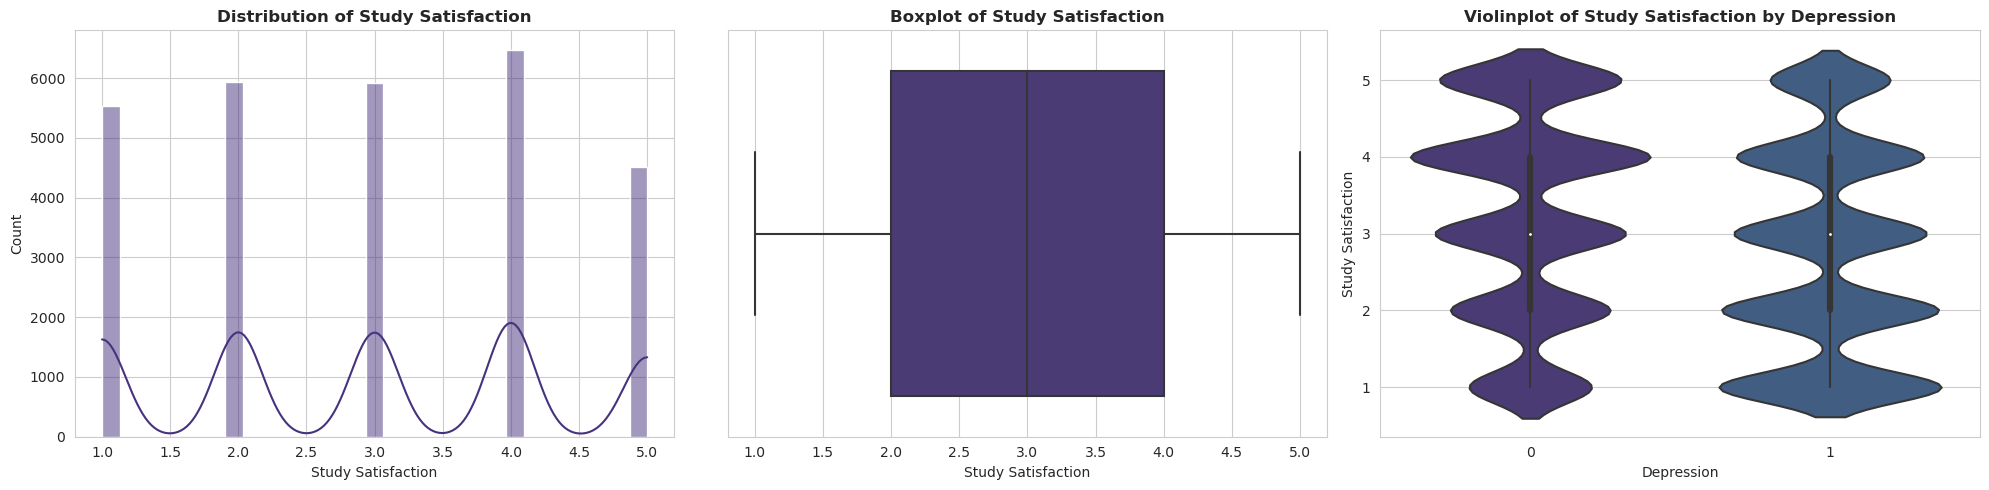

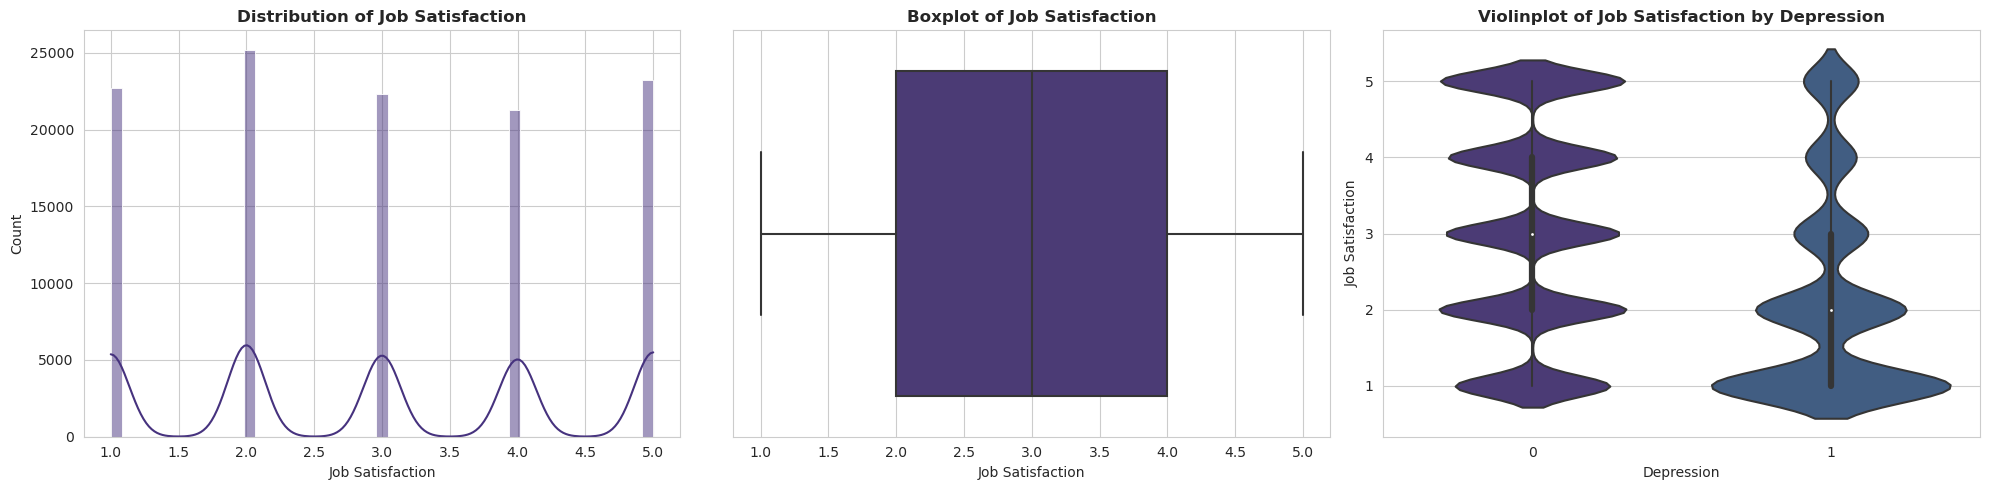

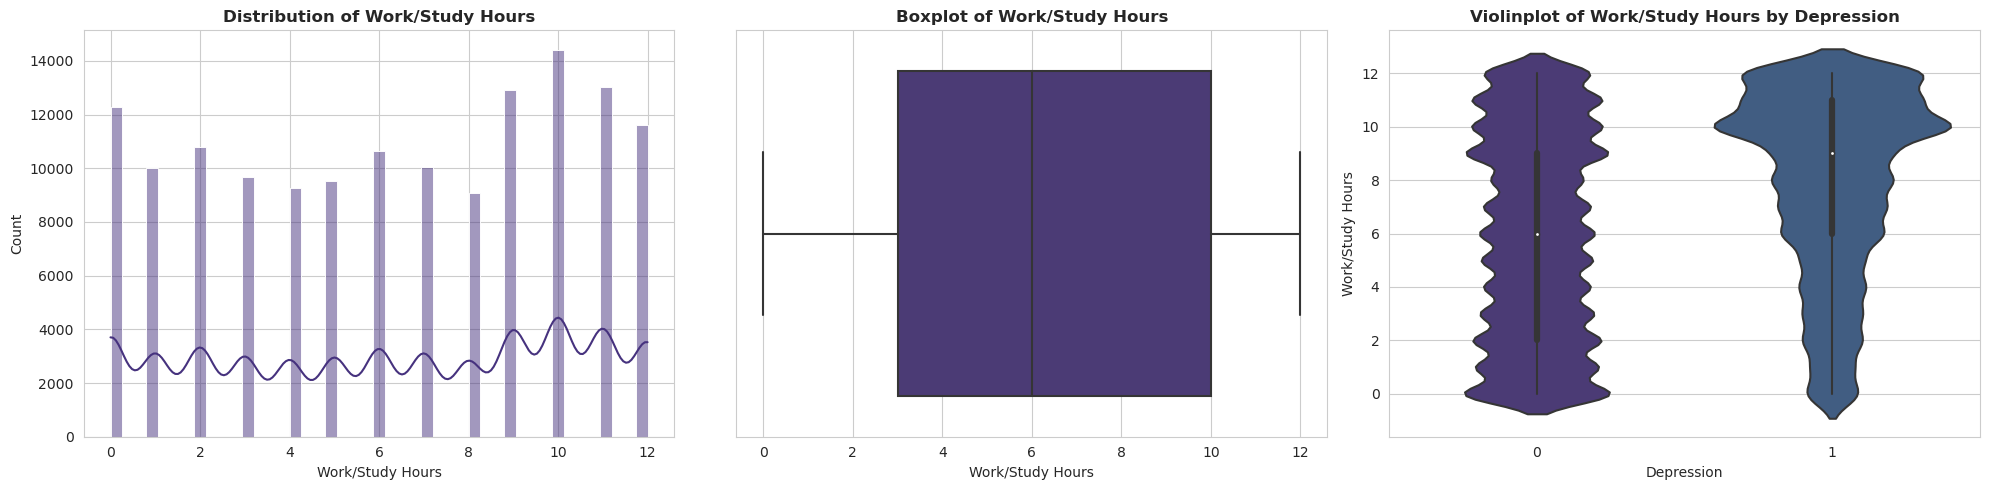

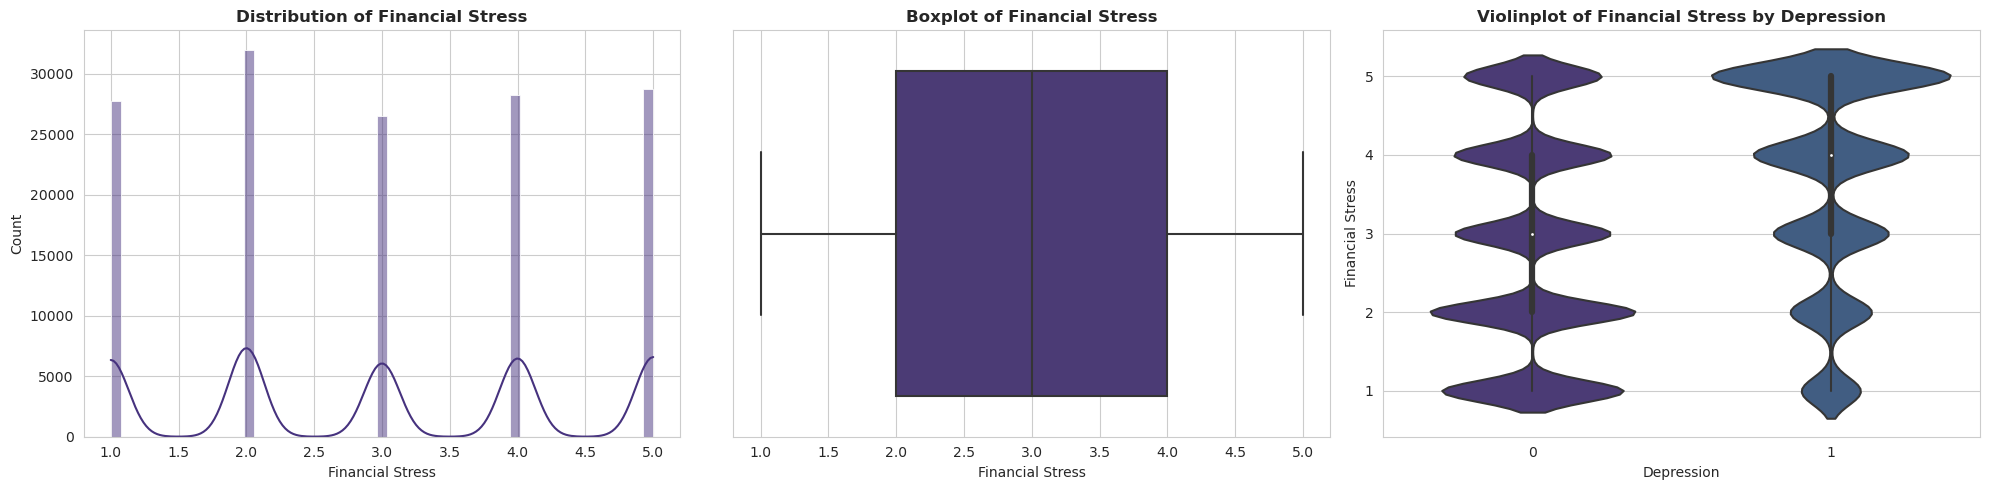

## Categorical Feature Attributes

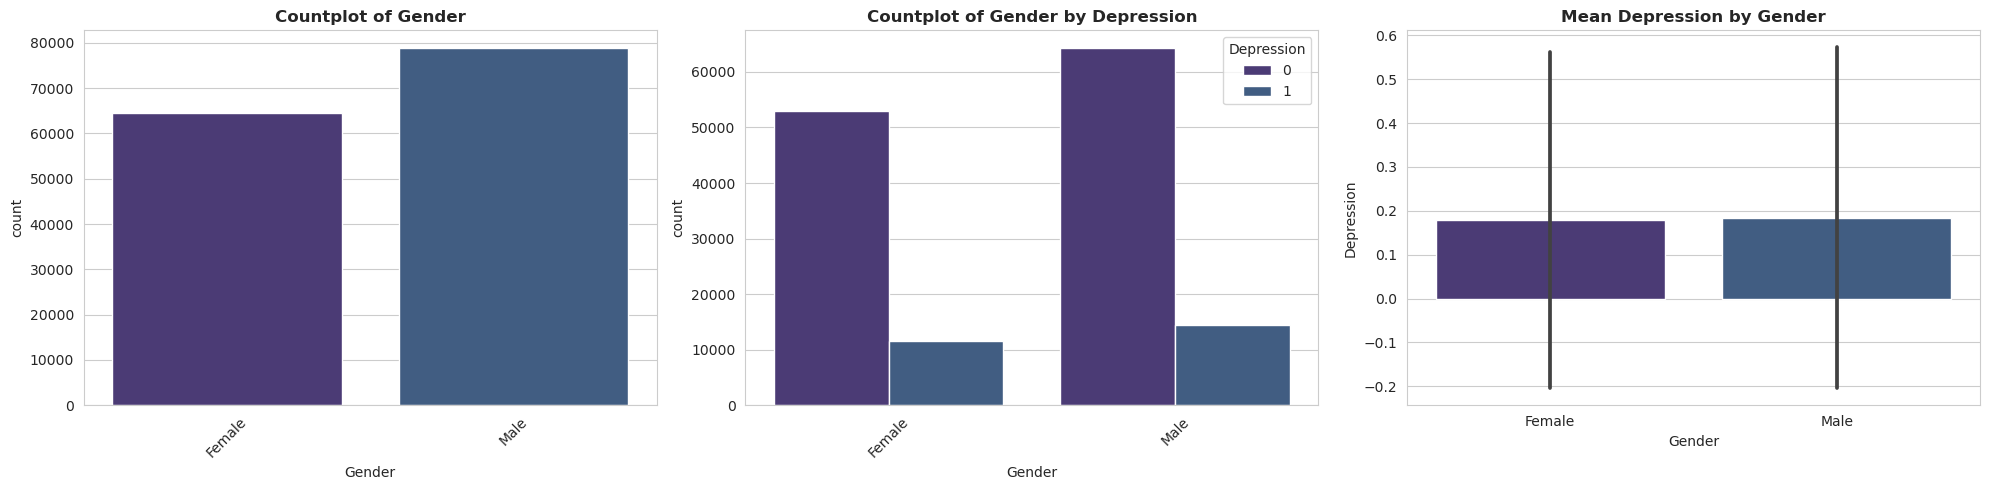

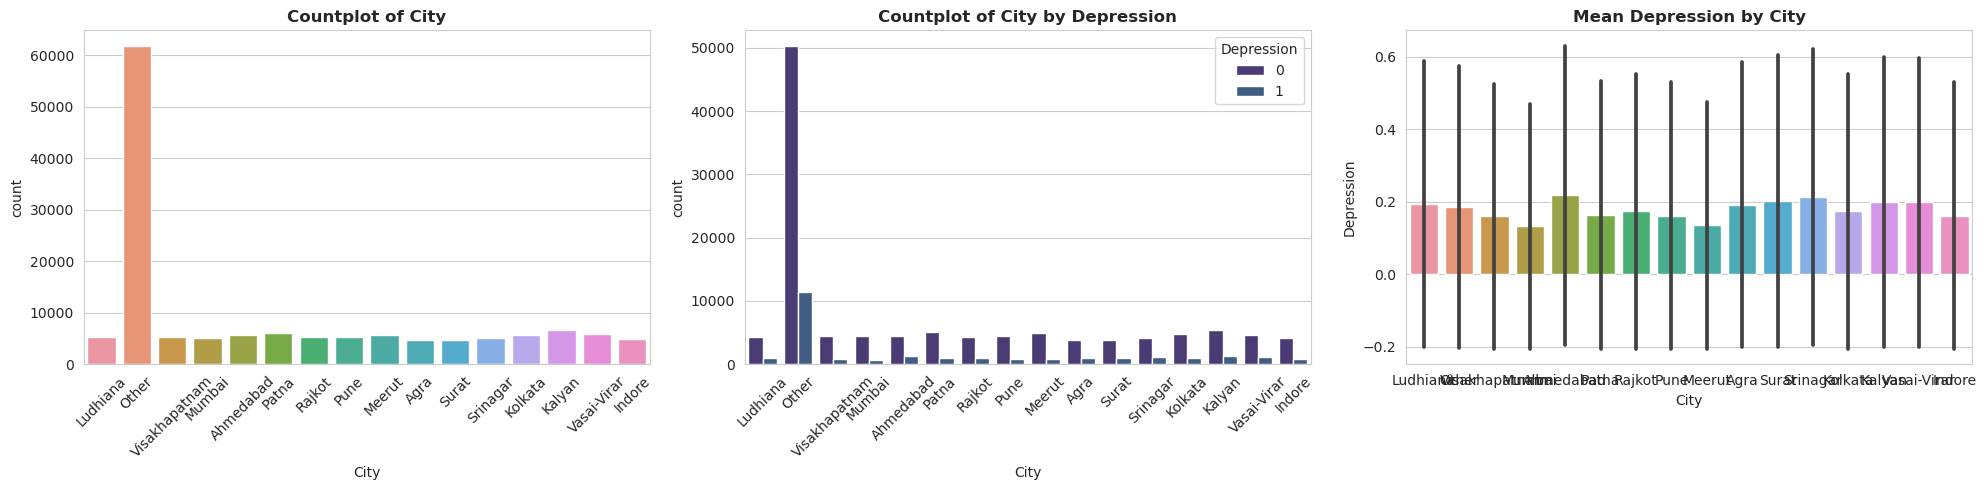

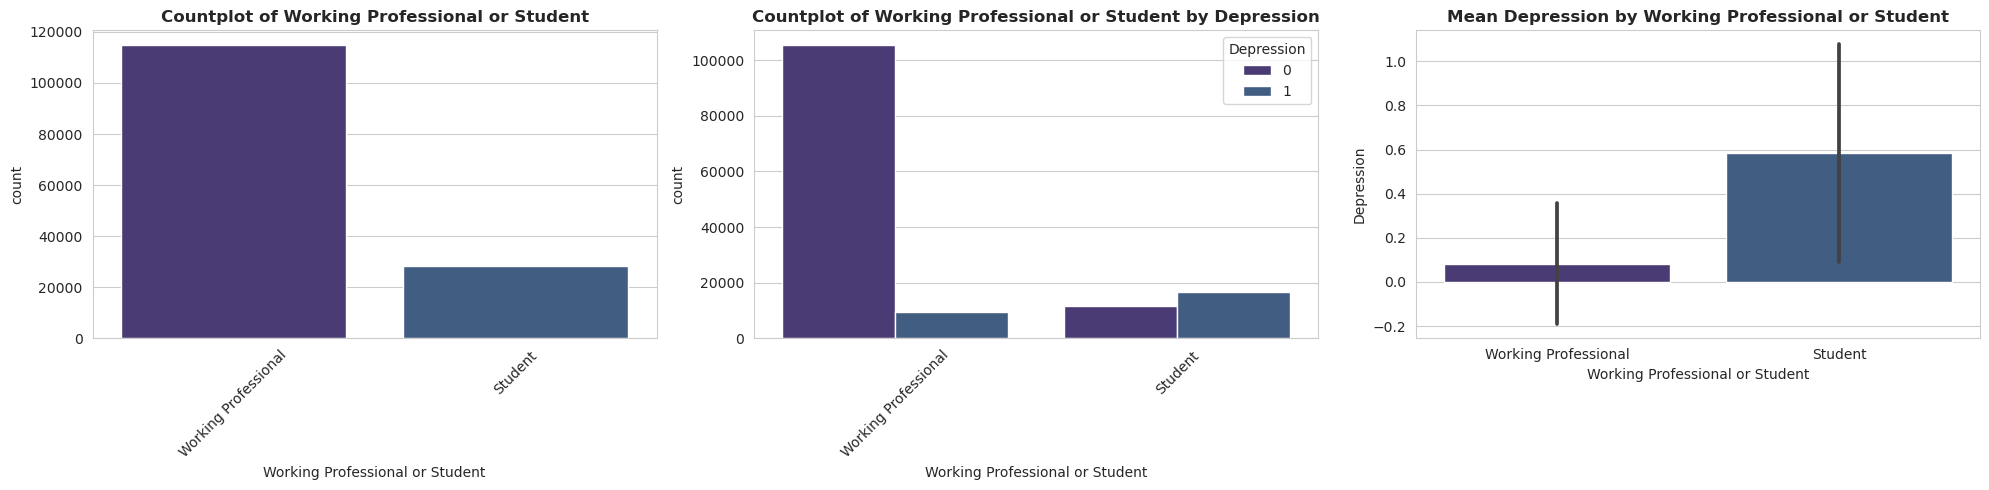

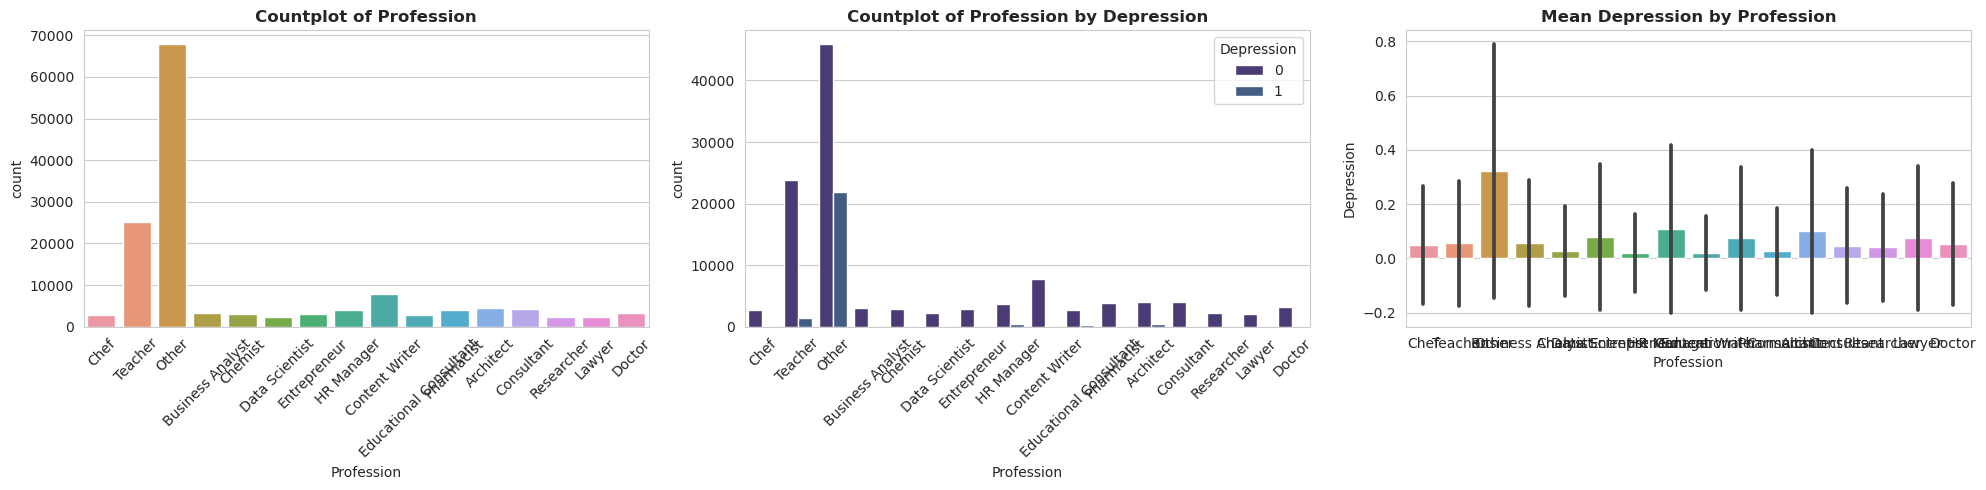

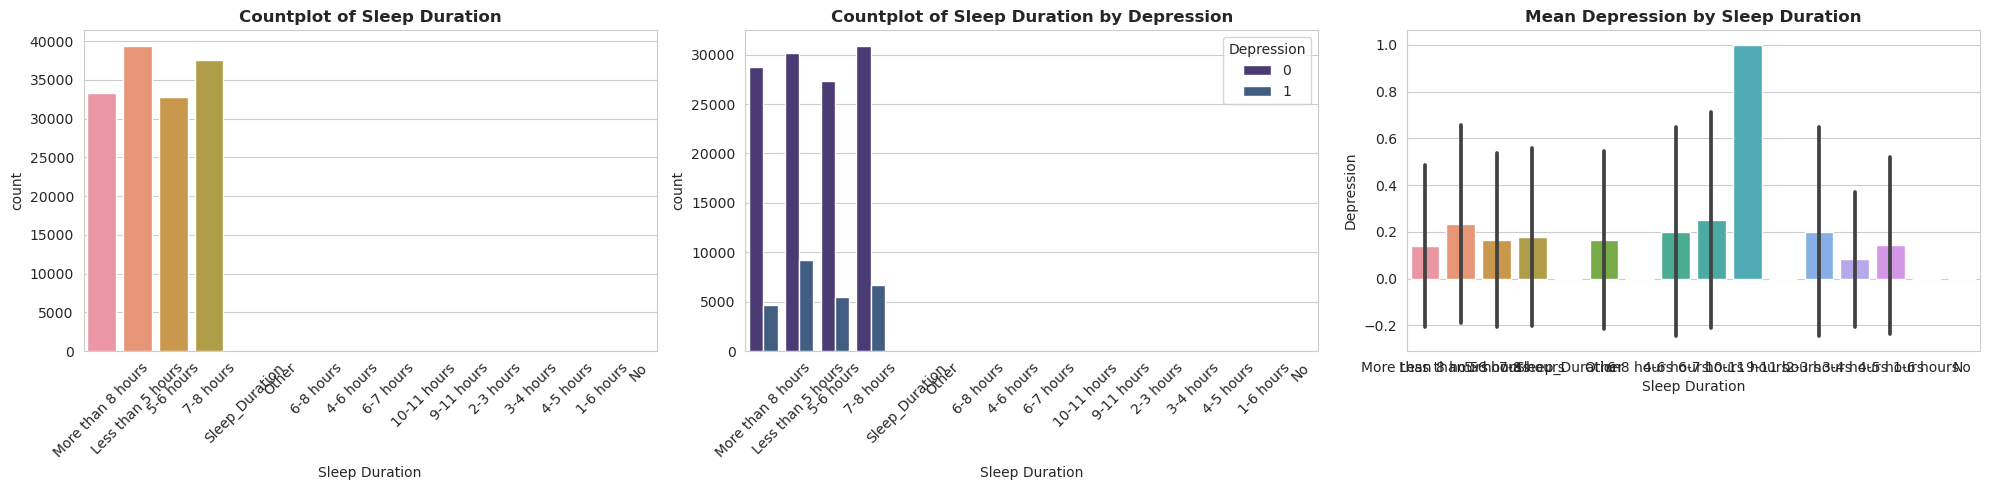

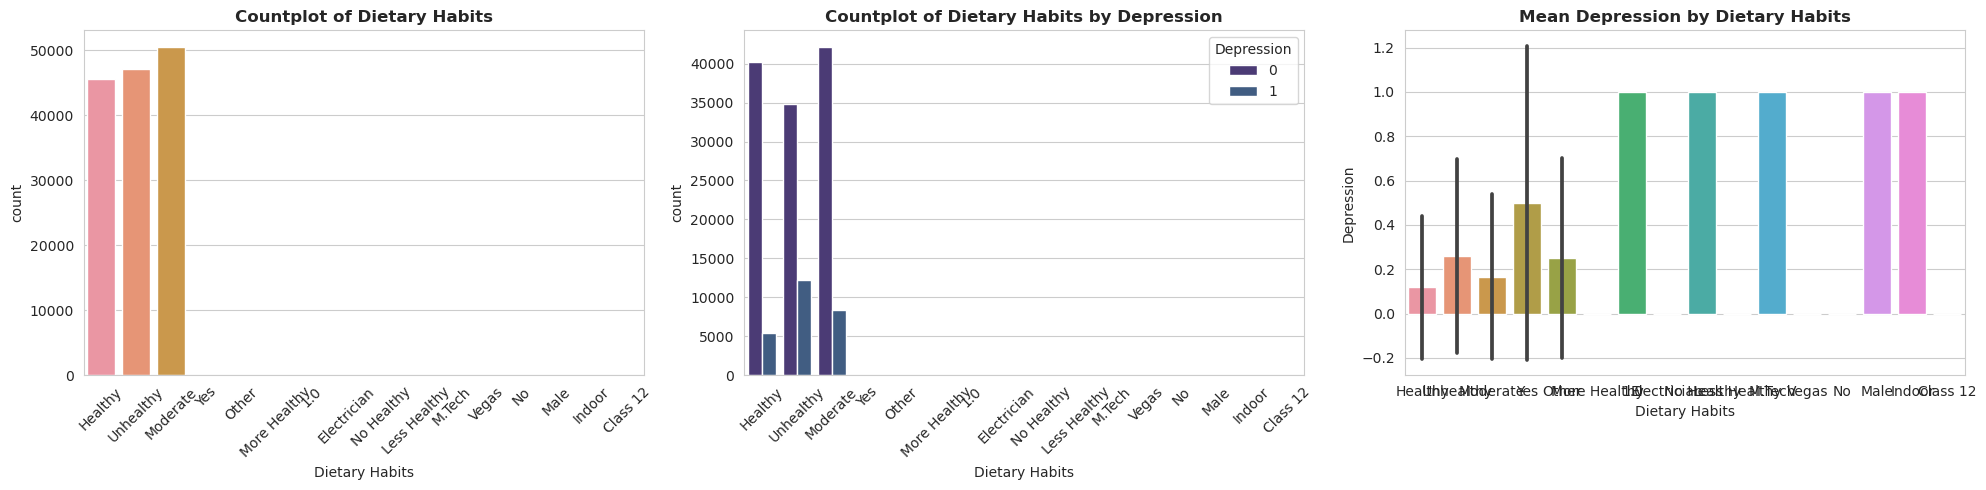

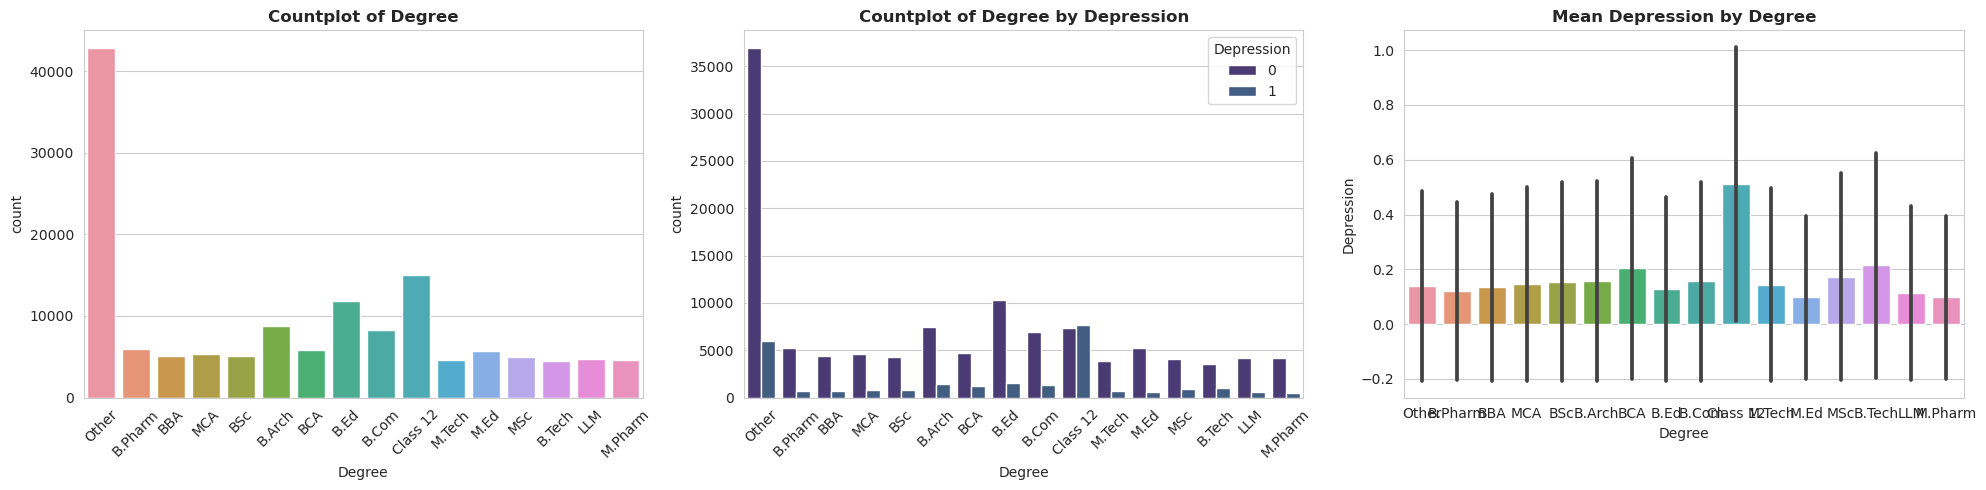

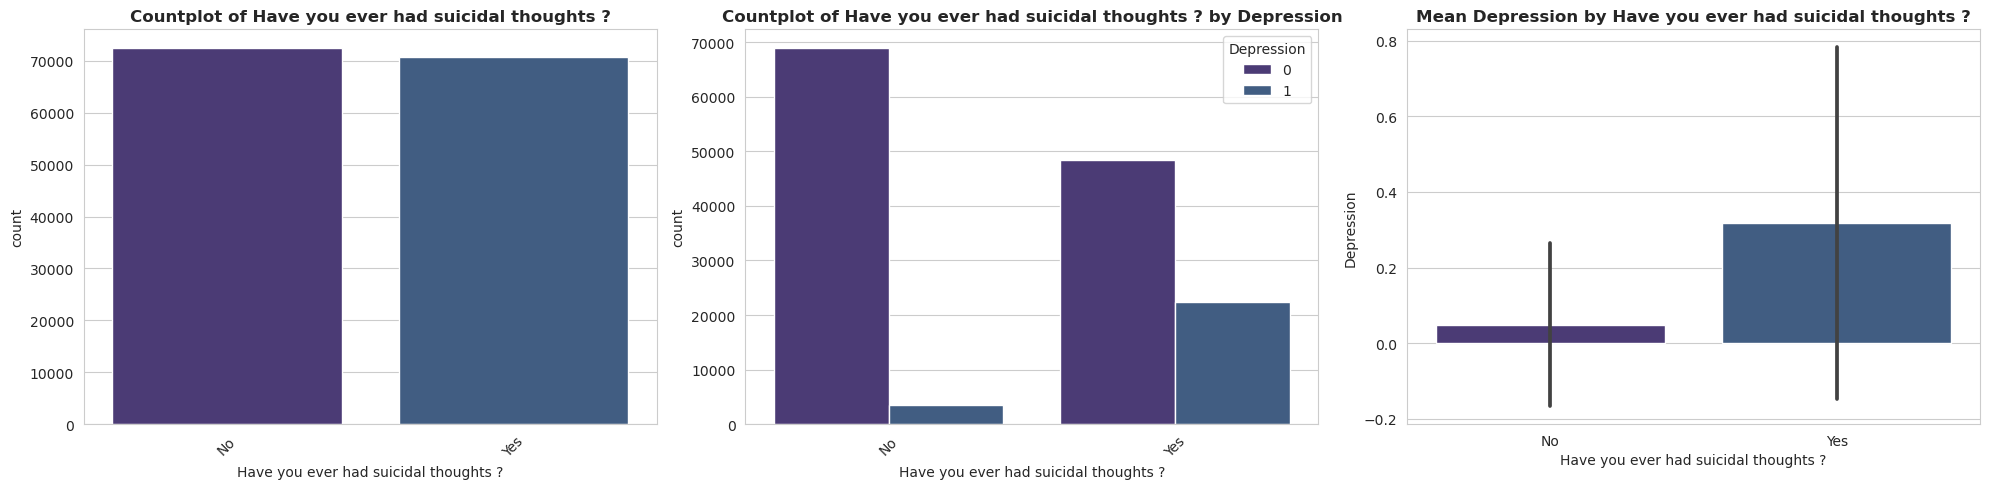

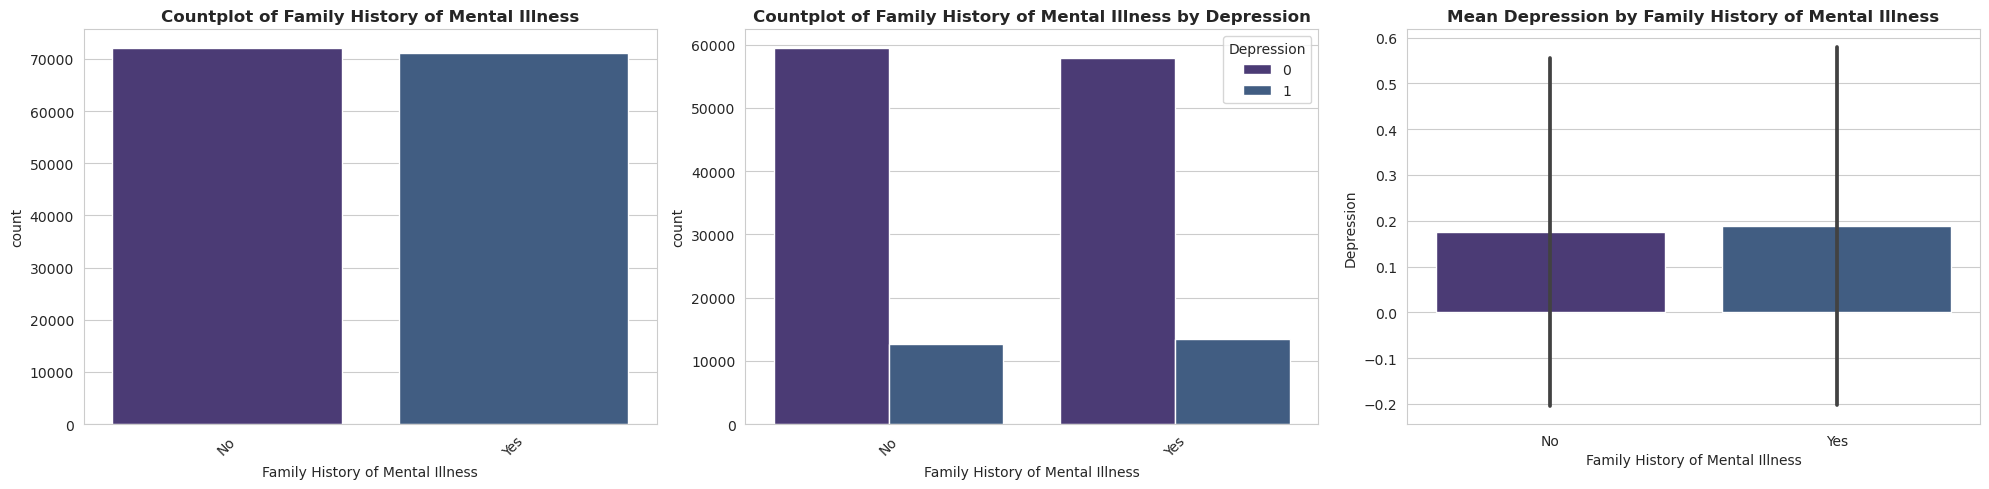

In [ ]:
def visualize_feature_attributes(df, target=None):
    """ Visualizes numeric and categorical features """

    # Get Numeric & Categorical Features
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Numeric Features
    if numeric_features:
        display(Markdown("## Numeric Feature Attributes"))
        for col in numeric_features:
            if col != target:
                plot_numeric_feature(df, col, target)
    else:
        print("No numeric features found.")

    # Categorical Features
    if categorical_features:
        display(Markdown("## Categorical Feature Attributes"))
        for col in categorical_features:
            if col != target:
                if df[col].nunique() > 10:
                    df = reduce_categories(df, col, top_n=15)
                plot_categorical_feature(df, col, target)
    else:
        print("No categorical features found.")


def plot_numeric_feature(df, col, target):
    """ Plots Histogram, Boxplot, and Violinplot for a numeric feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.histplot(df[col], ax=axes[0], kde=True)
    axes[0].set_title(f"Distribution of {col}", fontweight="bold")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}", fontweight="bold")

    if target and target in df.columns and df[target].nunique() == 2:
        sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=True)
    elif target and target in df.columns:
        sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=False)
    else:
        sns.violinplot(y=df[col], ax=axes[2])

    axes[2].set_title(f"Violinplot of {col} by {target}", fontweight="bold")

    plt.tight_layout()
    plt.show()


def plot_categorical_feature(df, col, target):
    """ Plots Countplot, Hue-Countplot, and Barplot (if target is numeric) for a categorical feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.countplot(x=df[col], ax=axes[0])
    axes[0].set_title(f"Countplot of {col}", fontweight="bold")
    axes[0].tick_params(axis='x', rotation=45)

    if target in df.columns:
        sns.countplot(x=df[col], hue=df[target], ax=axes[1])
        axes[1].set_title(f"Countplot of {col} by {target}", fontweight="bold")
        axes[1].tick_params(axis='x', rotation=45)

    if target in df.columns and df[target].dtype in [np.float64, np.int64]:
        sns.barplot(x=df[col], y=df[target], ax=axes[2], estimator=np.mean, errorbar='sd')
        axes[2].set_title(f"Mean {target} by {col}", fontweight="bold")
    else:
        axes[2].remove()  

    plt.tight_layout()
    plt.show()
    

def reduce_categories(df, col, top_n):
    """ Shows only the categories with highes numbers, seldoms are shown with "others" """
    top_categories = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df


# Beispiel-Aufruf mit train-Dataset:
visualize_feature_attributes(train.drop(columns=['Name']), target="Depression")

# Correlation